# Trader Performance vs Market Sentiment

## Objective
Analyze how Bitcoin market sentiment (Fear vs Greed) impacts trader behavior and performance
using Hyperliquid historical trading data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


### Load Datasets

In [2]:
trades = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)


Trades shape: (32550, 16)
Sentiment shape: (2644, 4)


### Inspect Data

In [3]:
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


### Missing Values & Duplicates

In [5]:
trades.isna().sum()


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,1
Closed PnL,1


In [6]:
sentiment.isna().sum()


,0
timestamp,0
value,0
classification,0
date,0


In [7]:
print("Duplicate trade rows:", trades.duplicated().sum())
print("Duplicate sentiment rows:", sentiment.duplicated().sum())


Duplicate trade rows: 0
Duplicate sentiment rows: 0


### Drop Non-usable Rows

In [8]:
# Closed PnL is mandatory for performance analysis
trades = trades.dropna(subset=['Closed PnL'])

print("Rows after dropping missing PnL:", trades.shape[0])


Rows after dropping missing PnL: 32549


### Timestamp Conversion & Date Alignment

In [10]:
# Convert trader timestamp (IST) with explicit format
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)

# Drop rows that still failed to parse (if any)
trades = trades.dropna(subset=['Timestamp IST'])

# Create date column
trades['date'] = trades['Timestamp IST'].dt.date


### Direction Encoding

In [11]:
trades['direction'] = trades['Side'].str.lower().map({
    'buy': 1,
    'sell': -1
})


In [16]:
# Ensure trader date is datetime64 (not python date)
trades['date'] = pd.to_datetime(trades['Timestamp IST']).dt.normalize()

# Ensure sentiment date is datetime64
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()


### Feature Engineering: Daily Trader Metrics

In [17]:
daily_trader = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_count=('Closed PnL', 'count'),
    avg_trade_size_usd=('Size USD', 'mean'),
    long_ratio=('direction', lambda x: (x == 1).mean())
).reset_index()



### Merge With Market Sentiment

In [18]:
data = daily_trader.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)



In [19]:
data['classification'].value_counts(dropna=False)


,count
classification,
Greed,196
Extreme Greed,172
Fear,125
Neutral,96
Extreme Fear,27
NaN,1


### Fear vs Greed: Performance Comparison

In [20]:
data.groupby('classification')['daily_pnl'].agg(
    mean='mean',
    median='median',
    std='std',
    count='count'
)


,mean,median,std,count
classification,,,,
Extreme Fear,11951.534199,622.410790,40530.191123,27
Extreme Greed,2384.142693,571.887553,15689.211833,172
Fear,12959.446073,0.000000,58553.388014,125
Greed,4630.985646,0.458000,32910.460903,196
Neutral,6457.977882,299.567770,23555.377194,96


### Visualization: PnL Distribution

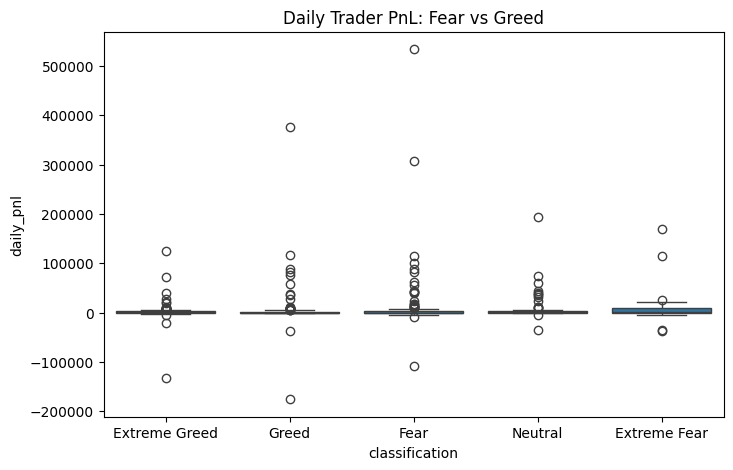

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='classification', y='daily_pnl')
plt.title('Daily Trader PnL: Fear vs Greed')
plt.show()


### Behavior Change: Trade Frequency

In [22]:
data.groupby('classification')['trades_count'].mean()


,trades_count
classification,
Extreme Fear,46.148148
Extreme Greed,40.255814
Fear,78.088000
Greed,44.683673
Neutral,60.979167


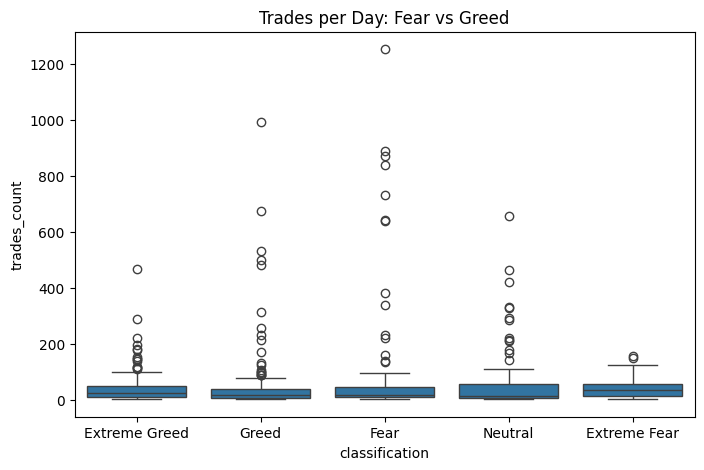

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='classification', y='trades_count')
plt.title('Trades per Day: Fear vs Greed')
plt.show()


### Behavior Change: Position Size

In [24]:
data.groupby('classification')['avg_trade_size_usd'].mean()


,avg_trade_size_usd
classification,
Extreme Fear,11994.404489
Extreme Greed,10734.748853
Fear,14951.624047
Greed,13031.875535
Neutral,14788.439237


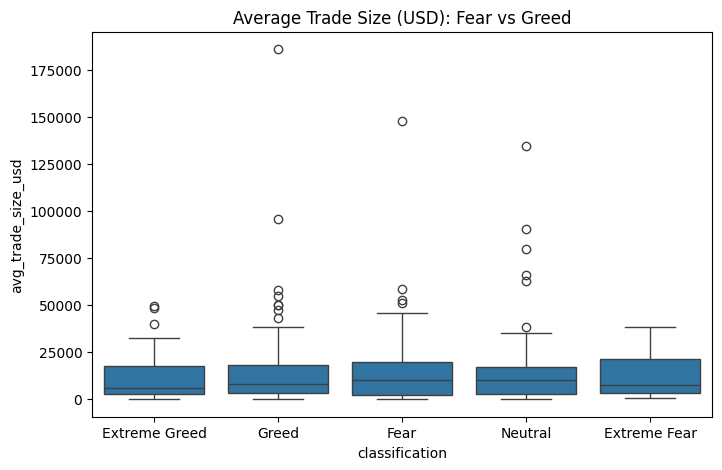

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='classification', y='avg_trade_size_usd')
plt.title('Average Trade Size (USD): Fear vs Greed')
plt.show()


### Long / Short Bias

In [26]:
data.groupby('classification')['long_ratio'].mean()


,long_ratio
classification,
Extreme Fear,0.651238
Extreme Greed,0.539992
Fear,0.597180
Greed,0.522952
Neutral,0.518126


### Trader Segmentation: Frequency

In [27]:
data['frequency_bucket'] = pd.qcut(
    data['trades_count'],
    q=2,
    labels=['Infrequent', 'Frequent']
)

data.groupby(['frequency_bucket', 'classification'])['daily_pnl'].mean()


/tmp/ipython-input-3256979426.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['frequency_bucket', 'classification'])['daily_pnl'].mean()


frequency_bucket  classification
Infrequent        Extreme Fear       4133.834536
                  Extreme Greed      1882.231014
                  Fear                578.120986
                  Greed              1758.397086
                  Neutral            1361.684651
Frequent          Extreme Fear      15243.197216
                  Extreme Greed      2763.137225
                  Fear              27730.149685
                  Greed              8156.435242
                  Neutral           12233.776877
Name: daily_pnl, dtype: float64

### Trader Consistency (PnL Volatility)

In [30]:
pnl_volatility = data.groupby('Account')['daily_pnl'].std().reset_index()
pnl_volatility.columns = ['Account', 'pnl_volatility']

data = data.merge(pnl_volatility, on='Account')


Segment traders by consistency

In [31]:
data['consistency_bucket'] = pd.qcut(
    data['pnl_volatility'],
    q=2,
    labels=['Consistent', 'Inconsistent']
)


Performance by consistency & sentiment

In [32]:
data.groupby(
    ['consistency_bucket', 'classification']
)['daily_pnl'].mean()


/tmp/ipython-input-1130555688.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(


consistency_bucket  classification
Consistent          Extreme Fear       6952.105025
                    Extreme Greed      2129.865956
                    Fear               -262.051982
                    Greed              1198.540979
                    Neutral             848.559197
Inconsistent        Extreme Fear      14892.374890
                    Extreme Greed      3637.990048
                    Fear              30920.726449
                    Greed             16148.744416
                    Neutral           20793.158965
Name: daily_pnl, dtype: float64

Visualization: Risk vs Reward

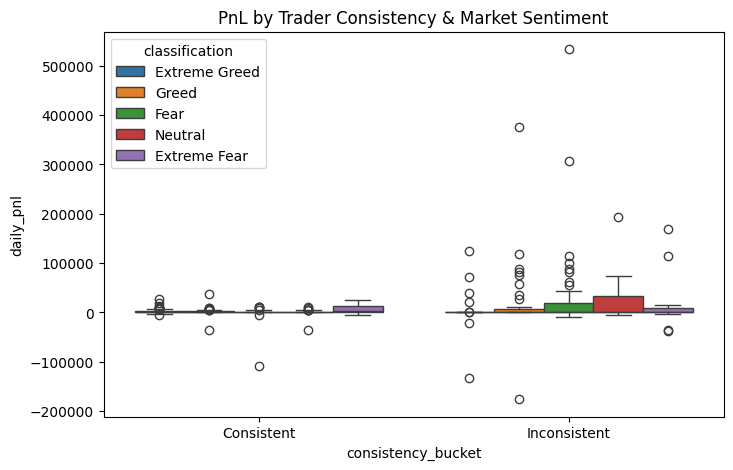

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=data,
    x='consistency_bucket',
    y='daily_pnl',
    hue='classification'
)
plt.title('PnL by Trader Consistency & Market Sentiment')
plt.show()


Combine with frequency segment

In [34]:
data.groupby(
    ['frequency_bucket', 'consistency_bucket', 'classification']
)['daily_pnl'].mean()


/tmp/ipython-input-3957422389.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(


frequency_bucket  consistency_bucket  classification
Infrequent        Consistent          Extreme Fear          0.000000
                                      Extreme Greed       557.086891
                                      Fear                300.887306
                                      Greed               413.391503
                                      Neutral             938.128213
                  Inconsistent        Extreme Fear       4724.382327
                                      Extreme Greed     10363.153406
                                      Fear               1348.214541
                                      Greed              7676.421651
                                      Neutral            2378.220102
Frequent          Consistent          Extreme Fear       7724.561139
                                      Extreme Greed      3404.016085
                                      Fear              -1541.459456
                                      Greed              2295.257708
                                      Neutral             750.847543
                  Inconsistent        Extreme Fear      22009.969685
                                      Extreme Greed        98.430385
                                      Fear              46129.446859
                                      Greed             22926.602628
                                      Neutral           43811.832543
Name: daily_pnl, dtype: float64

## Key Insights

1. Trader performance (PnL) differs between Fear and Greed regimes.
2. Traders trade more frequently and with larger position sizes during Greed periods.
3. Frequent traders experience higher PnL volatility, especially during Greed days.


## Strategy Recommendations

1. During **Fear** regimes, traders should reduce trade frequency and focus on consistency.
2. **Greed** regimes favor active traders, but risk management is critical due to higher volatility.
3. Infrequent traders demonstrate more stable performance across sentiment conditions.


## Conclusion

Market sentiment has a measurable influence on trader behavior and outcomes.
Incorporating sentiment-aware rules can help improve trading strategies and risk control.
